# mapping the ICU Coral Reef Watch current stress level and CFSv2 forecast with cartopy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patheffects
from matplotlib.transforms import offset_copy

import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import geopandas as gpd
import pandas as pd

%matplotlib inline

In [2]:
def rgb2hex(r,g,b): 
    
    def clamp(x): 
        return max(0, min(x, 255))
    
    h = "#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))
    
    return h

### 10 min. resolution coastlines / land

In [3]:
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='0.6',
                                        facecolor='0.9', linewidth=0.2)

### draw a blan map of the Pacific region

In [4]:
# crs = ccrs.Mercator(central_longitude=180., latitude_true_scale=0., min_latitude=-42.5, max_latitude=30.)
crs = ccrs.Mercator(central_longitude=180., latitude_true_scale=0., min_latitude=-32.5, max_latitude=25.)

In [5]:
def draw_Pacific(ax, extent = [120, -120, -45., 30]):
    ax.set_extent(extent)
    ax.add_feature(land_10m)

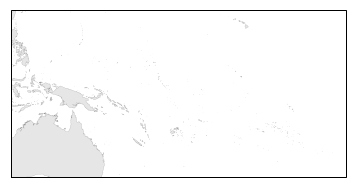

In [6]:
f, ax = plt.subplots(
    1, 1, figsize=(6, 8),
    subplot_kw=dict(projection=crs))
draw_Pacific(ax)

### read the shapefile with the ICU EEZ geometries

In [7]:
shape_gpd = gpd.read_file('/Users/nicolasf/data/GIS_map_files/ALL_ICU_countries.shp')

### reads the CRW table

In [8]:
table = pd.read_csv('../data/CRW_tables/BAA_obs_ICU_summary_201306_201712.csv', index_col=0, parse_dates=True)

In [9]:
table.head()

,American Samoa,Austral Islands,FSM,Fiji,Guam,Kiribati (Gilbert),Kiribati (Line),Kiribati (Phoenix),Marquesas,Marshall Islands,...,Society Islands,Solomon Islands,Southern Cook Islands,Tokelau,Tonga,Tuamotu/Gambier,Tuvalu,Vanuatu North,Vanuatu South,Wallis & Futuna
2013-06-30,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2013-07-31,0.0,0.0,2.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2013-08-31,1.0,0.0,2.0,0.0,3.0,2.0,1.0,1.0,0.0,2.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2013-09-30,1.0,0.0,3.0,0.0,4.0,2.0,1.0,1.0,0.0,2.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2013-10-31,0.0,0.0,3.0,0.0,4.0,1.0,1.0,1.0,0.0,3.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


### get the coral bleaching stress 

In [10]:
table = table.iloc[-1,:].to_frame(name='Stress')

In [11]:
table.head()

,Stress
American Samoa,1.0
Austral Islands,0.0
FSM,1.0
Fiji,1.0
Guam,1.0


### dictionarry with correct country names (matching the one in the shapefile)

In [12]:
dict_countries = {}

In [13]:
dict_countries['FSM'] = 'Federated States of Micronesia'
dict_countries['Kiribati (Gilbert)'] = 'Kiribati: Gilbert Islands'
dict_countries['Kiribati (Line)'] = 'Kiribati: Line Islands'
dict_countries['Kiribati (Phoenix)'] = 'Kiribati: Phoenix Islands'
dict_countries['Tuamotu/Gambier'] = 'Tuamotu / Gambier Islands'

### build dictionnary with level: colors for mapping of coral bleaching stress level (current)

Satellite:
```
 200 250 250    No Stress       (very light blue)
 255 240   0    Watch           (Yellow)     
 250 170  10    Warning         (Orange)
 240   0   0    Alert Level 1   (Red)
 150   0   0    Alert Level 2   (Dark Red)
```

In [14]:
current_BAA_rgb = [[200, 250, 250], [255, 240, 0], [250, 170, 10], [240, 0, 0], [150, 0, 0]]

Outlook:
```
 200 250 250    No Stress       (very light blue)
 255 210 160    Watch           (Beige)      
 250 170  10    Warning         (Orange)
 240   0   0    Alert Level 1   (Red)
 150   0   0    Alert Level 2   (Dark Red)
```

In [15]:
outlook_BAA_rgb = [[200, 250, 250], [255, 210, 160], [250, 170, 10], [240, 0, 0], [150, 0, 0]]

In [16]:
current_BAA_rgb = [rgb2hex(*x) for x in current_BAA_rgb]

In [17]:
outlook_BAA_rgb = [rgb2hex(*x) for x in outlook_BAA_rgb]

In [18]:
current_BAA_rgb = dict(zip(range(5), current_BAA_rgb))

In [19]:
outlook_BAA_rgb = dict(zip(range(5), outlook_BAA_rgb))

### some data munging prior to the merging of the shapefiles and the CRW table

In [20]:
table.loc[:,'COUNTRYNAM'] = table.index

In [21]:
table.head()

,Stress,COUNTRYNAM
American Samoa,1.0,American Samoa
Austral Islands,0.0,Austral Islands
FSM,1.0,FSM
Fiji,1.0,Fiji
Guam,1.0,Guam


In [22]:
table = table.replace({'COUNTRYNAM':dict_countries})

In [23]:
shape_gpd.head()

,COUNTRY_ID,COUNTRYNAM,ICU,Stress,SOPAC,FFA,SPC,SPREP,USP,TCSP,FORUM,ACP,area,geometry
0,NC,New Caledonia,2,-7,0,0,0,3,0,0,0,0,0.0,"POLYGON ((158.6108 -25.14667, 157.8011 -23.248..."
1,PN,Pitcairn Islands,2,2,0,0,0,2,0,0,0,0,0.0,"POLYGON ((-132.499382 -22.511733, -132.228513 ..."
2,PG,Papua New Guinea,-3,1,3,0,0,4,0,0,0,0,0.0,"POLYGON ((157.168058 -13.692712, 157.038334 -1..."
3,SB,Solomon Islands,2,10,2,0,0,4,0,0,0,0,0.0,"POLYGON ((173.5906 -11.85417, 173.525754 -12.5..."
4,KI,Kiribati: Phoenix Islands,-5,-13,0,0,0,0,0,0,0,0,0.0,"POLYGON ((-168.921636 -6.882211000000032, -170..."


In [24]:
shape_gpd = shape_gpd.loc[:,['COUNTRYNAM','geometry']]

### merge table + geopandas dataframe to have geometry and stress level in one dataframe

In [25]:
shape_gpd = shape_gpd.merge(table, on='COUNTRYNAM')

In [26]:
shape_gpd.head()

,COUNTRYNAM,geometry,Stress
0,New Caledonia,"POLYGON ((158.6108 -25.14667, 157.8011 -23.248...",1.0
1,Pitcairn Islands,"POLYGON ((-132.499382 -22.511733, -132.228513 ...",0.0
2,Papua New Guinea,"POLYGON ((157.168058 -13.692712, 157.038334 -1...",3.0
3,Solomon Islands,"POLYGON ((173.5906 -11.85417, 173.525754 -12.5...",2.0
4,Kiribati: Phoenix Islands,"POLYGON ((-168.921636 -6.882211000000032, -170...",1.0


### function to get the centroids of each geometry 

In [27]:
lons_lats = {}
for i, row in shape_gpd.iterrows():
    geom = row.geometry
    x = geom.centroid.xy[0][0]
    y = geom.centroid.xy[1][0]
    lons_lats[row.COUNTRYNAM] = np.array([x, y])    

In [28]:
lons_lats = pd.DataFrame(lons_lats).T

In [29]:
lons_lats.columns = ['lon','lat']

In [30]:
lons_lats

,lon,lat
American Samoa,-169.057020,-13.860065
Austral Islands,-148.382981,-25.274727
Federated States of Micronesia,150.338634,6.768646
Fiji,95.910563,-17.956943
Guam,144.071177,12.873073
Kiribati: Gilbert Islands,172.824061,-0.274344
Kiribati: Line Islands,-154.745665,-3.815289
Kiribati: Phoenix Islands,-172.445006,-3.731197
Marquesas,-139.678800,-8.903056
Marshall Islands,167.498711,10.119736


### data munging on the shape_gpd table

In [31]:
shape_gpd.set_index('COUNTRYNAM', drop=False, inplace=True)

In [32]:
shape_gpd.loc[:,'name_to_plot'] = shape_gpd.loc[:,'COUNTRYNAM']

In [33]:
# shape_gpd.loc[:,'lat_to_plot'] = 0.0

In [34]:
# shape_gpd.loc[:,'lon_to_plot'] = 0.0

In [35]:
shape_gpd.head()

,COUNTRYNAM,geometry,Stress,name_to_plot
COUNTRYNAM,,,,
New Caledonia,New Caledonia,"POLYGON ((158.6108 -25.14667, 157.8011 -23.248...",1.0,New Caledonia
Pitcairn Islands,Pitcairn Islands,"POLYGON ((-132.499382 -22.511733, -132.228513 ...",0.0,Pitcairn Islands
Papua New Guinea,Papua New Guinea,"POLYGON ((157.168058 -13.692712, 157.038334 -1...",3.0,Papua New Guinea
Solomon Islands,Solomon Islands,"POLYGON ((173.5906 -11.85417, 173.525754 -12.5...",2.0,Solomon Islands
Kiribati: Phoenix Islands,Kiribati: Phoenix Islands,"POLYGON ((-168.921636 -6.882211000000032, -170...",1.0,Kiribati: Phoenix Islands


In [36]:
shape_gpd.loc['Kiribati: Phoenix Islands','name_to_plot'] = 'Kiribati:\nPhoenix Islands'
shape_gpd.loc['Northern Cook Islands','name_to_plot'] = 'Northern\nCook Islands'
shape_gpd.loc['Kiribati: Line Islands','name_to_plot'] = 'Kiribati:\nLine Islands'
shape_gpd.loc['Kiribati: Gilbert Islands','name_to_plot'] = 'Kiribati:\nGilbert Islands'
shape_gpd.loc['Wallis & Futuna','name_to_plot'] = 'Wallis &\nFutuna'
shape_gpd.loc['Tuamotu / Gambier Islands','name_to_plot'] = 'Tuamotu / Gambier\nIslands'
shape_gpd.loc['Southern Cook Islands','name_to_plot'] = 'Southern\nCook Islands'
shape_gpd.loc['Vanuatu South','name_to_plot'] = 'Vanuatu\nSouth'
shape_gpd.loc['Vanuatu North','name_to_plot'] = 'Vanuatu\nNorth'
shape_gpd.loc['Northern Marianas','name_to_plot'] = 'Northern\nMarianas'
shape_gpd.loc['American Samoa','name_to_plot'] = 'American\nSamoa'

In [37]:
shape_gpd = shape_gpd.merge(lons_lats, left_index=True, right_index=True)

### function to make the choropleth

In [38]:
def make_choropleth(ax, shape_gpd, dict_colors=current_BAA_rgb):
    lons_lats = {}
    for i, row in shape_gpd.iterrows():
        v = int(row.Stress)
        color = dict_colors[v]
        geom = row.geometry
        lons_lats[row.COUNTRYNAM] = np.array([x, y])
        sp = ShapelyFeature([geom], ccrs.PlateCarree(),
                            edgecolor='k',
                            facecolor=color, lw=0.2)
        ax.add_feature(sp)

In [87]:
def make_legend(ax, facecolors=current_BAA_rgb, title = 'Current Heat Stress', subtitle = 'November maximum'):
    
    from matplotlib.patches import Rectangle
    
    xt = 0.8

    ax.text(xt, 0.95, title, fontsize=13, transform=ax.transAxes)
    ax.text(xt, 0.915, subtitle, fontsize=11, transform=ax.transAxes)

    ax.add_patch(Rectangle([xt, 0.85], 0.045, 0.045, facecolor=facecolors[0], transform=ax.transAxes))
    ax.add_patch(Rectangle([xt, 0.8], 0.045, 0.045, facecolor=facecolors[1], transform=ax.transAxes))
    ax.add_patch(Rectangle([xt, 0.75], 0.045, 0.045, facecolor=facecolors[2], transform=ax.transAxes))
    ax.add_patch(Rectangle([xt, 0.7], 0.045, 0.045, facecolor=facecolors[3], transform=ax.transAxes))
    ax.add_patch(Rectangle([xt, 0.65], 0.045, 0.045, facecolor=facecolors[4], transform=ax.transAxes))

    toffset_y = 0.015
    toffset_x = 0.05

    ax.text(xt + toffset_x, 0.85 + toffset, 'No Stress', transform=ax.transAxes)
    ax.text(xt + toffset_x, 0.8 + toffset, 'Watch', transform=ax.transAxes)
    ax.text(xt + toffset_x, 0.75 + toffset, 'Warning', transform=ax.transAxes)
    ax.text(xt + toffset_x, 0.7 + toffset, 'Alert Level 1', transform=ax.transAxes)
    ax.text(xt + toffset_x, 0.65 + toffset, 'Alert Level 2', transform=ax.transAxes)

### plot

In [39]:
shape_gpd

,COUNTRYNAM,geometry,Stress,name_to_plot,lon,lat
New Caledonia,New Caledonia,"POLYGON ((158.6108 -25.14667, 157.8011 -23.248...",1.0,New Caledonia,163.075425,-20.864542
Pitcairn Islands,Pitcairn Islands,"POLYGON ((-132.499382 -22.511733, -132.228513 ...",0.0,Pitcairn Islands,-127.470494,-24.568268
Papua New Guinea,Papua New Guinea,"POLYGON ((157.168058 -13.692712, 157.038334 -1...",3.0,Papua New Guinea,149.829278,-5.626700
Solomon Islands,Solomon Islands,"POLYGON ((173.5906 -11.85417, 173.525754 -12.5...",2.0,Solomon Islands,163.613350,-10.031313
Kiribati: Phoenix Islands,Kiribati: Phoenix Islands,"POLYGON ((-168.921636 -6.882211000000032, -170...",1.0,Kiribati:\nPhoenix Islands,-172.445006,-3.731197
Fiji,Fiji,"(POLYGON ((180 -24.19374749999997, 179.9925 -2...",1.0,Fiji,95.910563,-17.956943
Tuvalu,Tuvalu,"(POLYGON ((180 -12.93966796021255, 179.534732 ...",1.0,Tuvalu,72.913893,-7.823477
Northern Cook Islands,Northern Cook Islands,"POLYGON ((-160.451319 -15.51411699999988, -165...",1.0,Northern\nCook Islands,-161.931628,-10.678272
Kiribati: Line Islands,Kiribati: Line Islands,"POLYGON ((-147.071268 -11.21303400000009, -147...",0.0,Kiribati:\nLine Islands,-154.745665,-3.815289
Federated States of Micronesia,Federated States of Micronesia,"POLYGON ((160.93166 8.007843999999901, 160.933...",1.0,Federated States of Micronesia,150.338634,6.768646


In [40]:
shape_gpd.loc['Fiji','lon'] = 181
shape_gpd.loc['Tuvalu','lon'] = 180
shape_gpd.loc['Tuamotu / Gambier Islands','lon'] = shape_gpd.loc['Tuamotu / Gambier Islands','lon'] + 2
shape_gpd.loc['Kiribati: Gilbert Islands','lon'] = shape_gpd.loc['Kiribati: Gilbert Islands','lon'] + 2
shape_gpd.loc['Wallis & Futuna','lon'] = shape_gpd.loc['Wallis & Futuna','lon'] - 3
shape_gpd.loc['Wallis & Futuna','lat'] = shape_gpd.loc['Wallis & Futuna','lat'] + 1
shape_gpd.loc['American Samoa','lon'] = shape_gpd.loc['American Samoa','lon'] + 2
shape_gpd.loc['Samoa','lat'] = shape_gpd.loc['Samoa','lat'] - 1

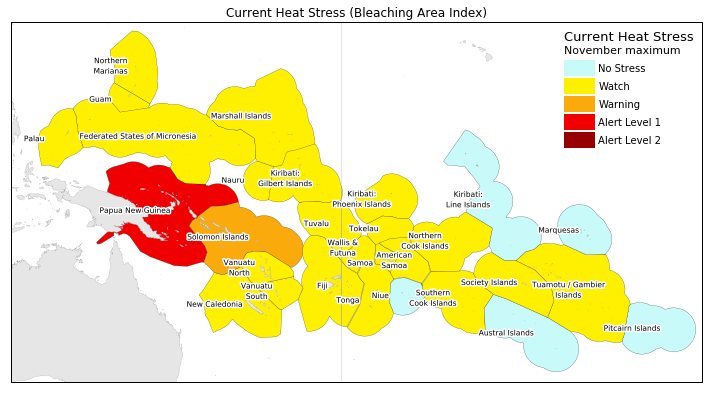

In [88]:
f, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=crs))

make_choropleth(ax, shape_gpd)

draw_Pacific(ax, extent = [125, -120, -32.5, 25])

ax.set_title('Current Heat Stress (Bleaching Area Index)')

transform = ccrs.PlateCarree()._as_mpl_transform(ax)

text_transform = offset_copy(transform, units='dots', x=-25)

for i, row in shape_gpd.iterrows(): 
    cname = row.name_to_plot
    lon = row.lon
    lat = row.lat
    txt = ax.text(lon, lat, cname, color='k', verticalalignment='center', horizontalalignment='center',
                 transform=text_transform, fontsize=7.5)
    txt.set_path_effects([patheffects.withStroke(linewidth=3, foreground='w')])

make_legend(ax)

ax.axvline(180, color='0.8', lw=0.5)

f.tight_layout()

f.savefig('/Users/nicolasf/Desktop/ICU_CRW_current_heat_stress_tryout.png', dpi=300)